No gemflag is provided, assuming the model includes biogem and ecogem
No gemflag is provided, assuming the model includes biogem and ecogem
No gemflag is provided, assuming the model includes biogem and ecogem


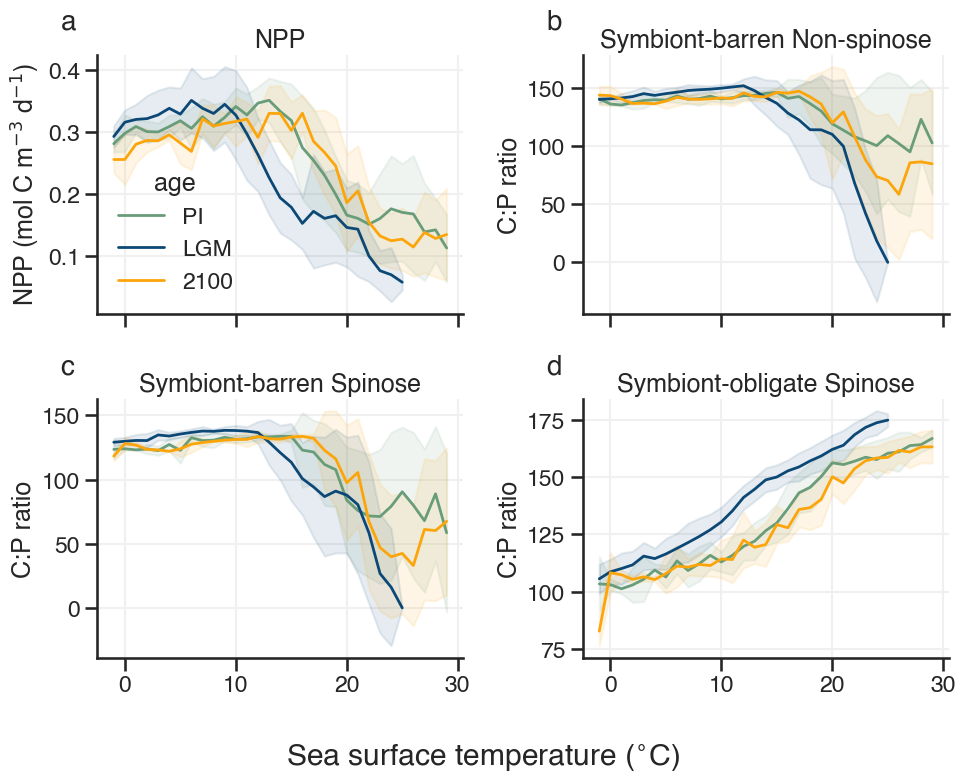

In [19]:
import pandas as pd
import seaborn as sns
from cgeniepy.ecology import EcoModel

colors = ["#699c79", "#0C4876"]
sst_bins = range(-1, 30)

## bin a model data according to SST
def bin_variable(model, variable, age_label, bin_res=1):
    values = model.get_var(variable).isel(time=-1).array.values.flatten()
    sst = model.get_var('ocn_sur_temp').isel(time=-1).array.values.flatten()
    bins = range(-1, 30, bin_res)
    
    values_binned = [values[(sst >= b) & (sst < b + 1)] for b in bins]
    
    ## merge into dataframes
    df = pd.DataFrame({'sst': bins, 'age': age_label, variable: values_binned})
    return df

def bin_stoichiometry(model, foram, age_label, bin_res=1):
    c = model.get_foram(foram, 'Biomass', "C").isel(time=-1).array.values.flatten()
    p = model.get_foram(foram, 'Biomass', "P").isel(time=-1).array.values.flatten()
    sst = model.get_var('ocn_sur_temp').isel(time=-1).array.values.flatten()
    bins = range(-1, 30, bin_res)
    
    c_to_p = c / p
    c_to_p_binned = [c_to_p[(sst >= b) & (sst < b + 1)] for b in bins]
    
    ## merge into dataframes
    df = pd.DataFrame({'sst': bins, 'age':age_label, 'stoichiometry': c_to_p_binned})
    
    return df

def bin_ensemble_variable(models,variable,model_label):
    df_list = []
    for i, model in enumerate(models):
        df_list.append(bin_variable(model, variable, model_label[i]).explode(variable))    
    
    ## merge into dataframes
    df = pd.concat(df_list)
    df_long = pd.melt(df, id_vars=['sst', 'age'], 
                      value_vars=[variable], 
                      var_name='variable',
                      value_name='value')

    return df_long

def bin_ensemble_stoichiometry(models,foram,model_label):
    df_list = []
    for i, model in enumerate(models):
        df_list.append(bin_stoichiometry(model, foram, model_label[i]).explode('stoichiometry'))

        ## merge into dataframes
    df = pd.concat(df_list)
    df_long = pd.melt(df, id_vars=['sst', 'age'],
                      value_vars=['stoichiometry'],
                      var_name='variable',
                      value_name='value')

    return df_long

pi_model = EcoModel('../model/muffin.CBE.worlg4.BASESFeTDTL.diag')
future_model = EcoModel('../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg')
lgm_model = EcoModel('../model/muffin.CBE.GIteiiva.BASESFeTDTL_rb.diag')

model_list = [pi_model, lgm_model, future_model]
model_label = ['PI', 'LGM', '2100']

d1 = bin_ensemble_variable(model_list, 'eco2D_Uptake_Fluxes_C', model_label)
d2 = bin_ensemble_stoichiometry(model_list, 'bn', model_label)
d3 = bin_ensemble_stoichiometry(model_list, 'bs', model_label)
d4 = bin_ensemble_stoichiometry(model_list, 'ss', model_label)

## plot in one figure
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(10, 8), nrows=2, ncols=2, sharex=True, tight_layout=True)

## plot using seaborn
def set_theme(base_family="helvetica"):

    custom_params = {
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.grid": True,
        "grid.color": "#f0f0f0",
        "grid.linewidth": 1.5,
        'lines.linewidth': 2,
        'legend.frameon': False,
        'legend.loc': 'lower left',
    }

    sns.set_theme(context='talk', style='ticks', font=base_family, rc=custom_params)

set_theme()
colors = ["#699c79", "#0C4876", "#fca50a"]
fig.supxlabel('Sea surface temperature ($^{\circ}$C)')

  
axs[0, 0].set_ylabel('NPP (mol C m$^{-3}$ d$^{-1}$)')
axs[0, 0].set_title('NPP')

axs[0, 1].set_ylabel('C:P ratio')
axs[0, 1].set_title('Symbiont-barren Non-spinose')

axs[1, 0].set_ylabel('C:P ratio')
axs[1, 0].set_title('Symbiont-barren Spinose')
axs[1, 0].set_ylabel('C:P ratio')

axs[1, 1].set_ylabel('C:P ratio')
axs[1, 1].set_title('Symbiont-obligate Spinose')
axs[1, 1].set_ylabel('C:P ratio')


sns.lineplot(data=d1, x='sst', y='value', hue='age', errorbar='sd',
             palette=colors, ax=axs[0, 0], err_kws={'alpha': 0.1})
sns.lineplot(data=d2, x='sst', y='value', hue='age', errorbar='sd',
             palette=colors, ax=axs[0, 1], legend=False, err_kws={'alpha': 0.1})
sns.lineplot(data=d3, x='sst', y='value', hue='age', errorbar='sd',
              palette=colors, ax=axs[1, 0], legend=False, err_kws={'alpha': 0.1})
sns.lineplot(data=d4, x='sst', y='value', hue='age', errorbar='sd',
                palette=colors, ax=axs[1, 1], legend=False,err_kws={'alpha': 0.1})

## remove all x axis label
letters = ['a', 'b', 'c', 'd']
for i, ax in enumerate(axs.flatten()):
    ax.xaxis.label.set_visible(False)
    ax.text(-0.1, 1.1, letters[i], transform=ax.transAxes,
            size=20, weight='bold')

## save to figure
fig.savefig('../output/fig4.pdf', dpi=300, bbox_inches='tight')